In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!gdown --id '1nr6aq1ykSM8pMIWlzeLRyJ3HradIO5gc'

Downloading...
From: https://drive.google.com/uc?id=1nr6aq1ykSM8pMIWlzeLRyJ3HradIO5gc
To: /content/train.zip
1.72GB [00:11, 155MB/s] 


In [ ]:
!gdown --id '1WgNQAEvRkotCYE3IHdcuxhLwAlp5oa90'

Downloading...
From: https://drive.google.com/uc?id=1WgNQAEvRkotCYE3IHdcuxhLwAlp5oa90
To: /content/test.zip
90.5MB [00:03, 29.0MB/s]


In [ ]:
import pandas as pd
import numpy as np
import os
import imageio
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
!unzip -q /content/test.zip
!unzip -q /content/train.zip

replace __MACOSX/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace __MACOSX/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!ls /content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
train_dir = '/content/train/'

counter = defaultdict(int)
for cls in os.listdir(train_dir):
  if not cls.startswith('.'):
    counter[cls] = len(os.listdir(train_dir + cls))

counter

defaultdict(int,
            {'Black-grass': 263,
             'Charlock': 390,
             'Cleavers': 287,
             'Common Chickweed': 611,
             'Common wheat': 221,
             'Fat Hen': 475,
             'Loose Silky-bent': 654,
             'Maize': 221,
             'Scentless Mayweed': 516,
             'Shepherds Purse': 231,
             'Small-flowered Cranesbill': 496,
             'Sugar beet': 385})

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text major ticklabel objects>)

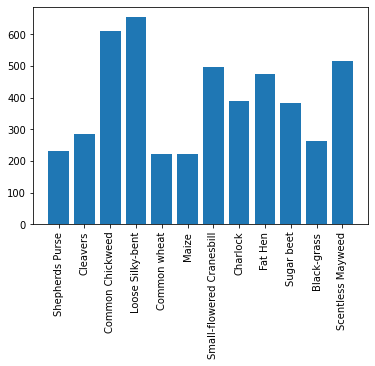

In [ ]:
plt.bar(counter.keys(), counter.values())
plt.xticks(rotation=90)

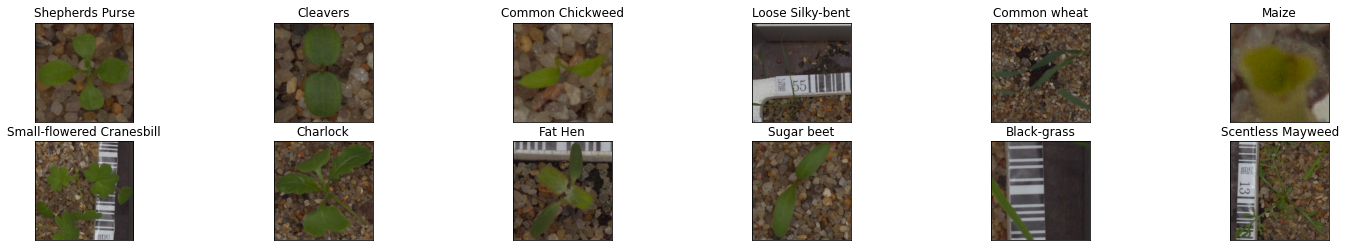

In [ ]:
from PIL import Image, ImageOps
fig = plt.figure(figsize=(25,4))

for i in np.arange(len(counter)):
  ax = fig.add_subplot(2, 6 , i+1, xticks=[], yticks=[])
  path = train_dir+list(counter.keys())[i]
  im = os.listdir(path)[1]
  img = Image.open(path+'/'+im)
  plt.imshow(img) 
  ax.set_title(list(counter.keys())[i])

Data engineering 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from skimage.transform import resize

In [ ]:
CLASS = {
    'Black-grass': 0,
    'Charlock': 1,
    'Cleavers': 2,
    'Common Chickweed': 3,
    'Common wheat': 4,
    'Fat Hen': 5,
    'Loose Silky-bent': 6,
    'Maize': 7,
    'Scentless Mayweed': 8,
    'Shepherds Purse': 9,
    'Small-flowered Cranesbill': 10,
    'Sugar beet': 11
}

Trans_CLASS = {
    0: 'Black-grass',
    1: 'Charlock',
    2: 'Cleavers',
    3: 'Common Chickweed',
    4: 'Common wheat',
    5: 'Fat Hen',
    6: 'Loose Silky-bent',
    7: 'Maize',
    8: 'Scentless Mayweed',
    9: 'Shepherds Purse',
    10: 'Small-flowered Cranesbill',
    11: 'Sugar beet'
}

In [ ]:
plant_label = [] 
plant_imgs = [] 
imgs_size = 51
for dirPath, dirNames, fileNames in os.walk('/content/train/'):
  if dirNames != []:
    print('Root:\n'+str(dirPath))
    print('Dirs:\n'+str(dirNames))
  else:
    for file in fileNames:
      if file[-3:] != 'png':
        continue
      plant_label.append(dirPath.split('/')[-1])
      im = Image.open(str(dirPath)+'/'+file)
      plant_imgs.append(ImageOps.fit(im, (imgs_size, imgs_size)).convert('RGB'))

Root:
/content/train/
Dirs:
['Shepherds Purse', 'Cleavers', 'Common Chickweed', 'Loose Silky-bent', 'Common wheat', 'Maize', 'Small-flowered Cranesbill', 'Charlock', 'Fat Hen', 'Sugar beet', 'Black-grass', 'Scentless Mayweed']


In [ ]:
imgs = np.array([np.array(im) for im in plant_imgs])
imgs = imgs.reshape(imgs.shape[0], imgs_size, imgs_size, 3) / 255 

In [ ]:
lb = LabelBinarizer().fit(plant_label) 
label = lb.transform(plant_label) 

In [ ]:
trainX, validX, trainY, validY = train_test_split(imgs, label, test_size=0.15, random_state=100)

In [ ]:
import keras
from keras.models import Model,load_model
from keras.layers import Input, Dense, Flatten, Activation, Dropout, Maximum, \
 BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU

model creating

In [ ]:
def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1)):
   zp = feature_batch
   conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
   bn = BatchNormalization(axis=3)(conv)
   act = LeakyReLU(1/10)(bn)
   return act

def dense_set(inp_layer, n, activation, drop_rate=0.):
  dp = Dropout(drop_rate)(inp_layer)
  dns = Dense(n)(dp)
  bn = BatchNormalization(axis=-1)(dns)
  act = Activation(activation=activation)(bn)
  return act

In [ ]:
model = keras.Sequential()
input = Input((imgs_size, imgs_size, 3)) # 51, 51
conv1 = conv_layer(input, 64)
conv2 = conv_layer(conv1, 64)
mp1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)#23, 23

conv3 = conv_layer(mp1, 128)
conv4 = conv_layer(conv3, 128)
mp2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv4)#9, 9

conv5 = conv_layer(mp2, 256)#7 ,7
conv6 = conv_layer(conv5, 256)#5, 5 
conv7 = conv_layer(conv6, 256)#3, 3
mp3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv7)#1, 1

flat = Flatten()(mp3)

ds1 = dense_set(flat, 128, activation='tanh')
out = dense_set(ds1, 12, activation='softmax')

model = Model(inputs=input, outputs=out)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-3), metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 51, 51, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 49, 49, 64)        1792      
_________________________________________________________________
batch_normalization_9 (Batch (None, 49, 49, 64)        256       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 47, 47, 64)        0   

train model

In [ ]:
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.callbacks import ModelCheckpoint

batch_size = 20
epochs = 200
learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x,verbose = 1)


earlystop = EarlyStopping(patience=30) 

modelsave = ModelCheckpoint(filepath='model.h5', save_best_only=True, verbose=1)

model_value = model.fit(trainX, trainY, batch_size=batch_size,
                        epochs= epochs, 
                        validation_data=(validX, validY),
                        callbacks=[learning_rate, earlystop, modelsave])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
202/202 [==============================] - 4s 15ms/step - loss: 1.7700 - acc: 0.4308 - val_loss: 3.2241 - val_acc: 0.1599

Epoch 00001: val_loss improved from inf to 3.22406, saving model to model.h5
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009000000000000001.
202/202 [==============================] - 3s 13ms/step - loss: 1.0349 - acc: 0.7214 - val_loss: 3.0660 - val_acc: 0.1781

Epoch 00002: val_loss improved from 3.22406 to 3.06604, saving model to model.h5
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008100000000000001.
202/202 [==============================] - 3s 14ms/step - loss: 0.8499 - acc: 0.7698 - val_loss: 1.5845 - val_acc: 0.5049

Epoch 00003: val_loss improved from 3.06604 to 1.58451, saving model to model.h5
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007290000000000002.
202/202 [===========

augmentation

In [ ]:
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                          width_shift_range=0.2, height_shift_range=0.2, 
                          shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
# train the network
model_value_aug = model.fit_generator(aug.flow(trainX, trainY, batch_size=batch_size),
                                  validation_data=(validX, validY), 
                                  steps_per_epoch=len(trainX) // batch_size,
                                  epochs=epochs,
                                  callbacks=[learning_rate, earlystop, modelsave])

Epoch 1/200

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


201/201 [==============================] - 5s 22ms/step - loss: 1.1317 - acc: 0.6293 - val_loss: 1.4450 - val_acc: 0.5175

Epoch 00001: val_loss did not improve from 0.21669
Epoch 2/200

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0009000000000000001.
201/201 [==============================] - 4s 22ms/step - loss: 0.8084 - acc: 0.7262 - val_loss: 0.4677 - val_acc: 0.8541

Epoch 00002: val_loss did not improve from 0.21669
Epoch 3/200

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0008100000000000001.
201/201 [==============================] - 4s 22ms/step - loss: 0.6677 - acc: 0.7819 - val_loss: 1.0781 - val_acc: 0.6424

Epoch 00003: val_loss did not improve from 0.21669
Epoch 4/200

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0007290000000000002.
201/201 [==============================] - 4s 22ms/step - loss: 0.6294 - acc: 0.7981 - val_loss: 1.0153 - val_acc: 0.6704

Epoch 00004: val_loss did not improve from 0.21669
Epoch 5/200



Testing

In [ ]:
test_label = [] 
test_imgs = [] 
imgs_size = 51
test_dir = '/content/test/'
for file in os.listdir(test_dir):
  if file[-3:] != 'png':
    continue
  test_label.append(file)
  im = Image.open(str(test_dir)+file)
  test_imgs.append(ImageOps.fit(im, (imgs_size, imgs_size)).convert('RGB'))

test_imgs = np.array([np.array(im) for im in test_imgs])
test_imgs = test_imgs.reshape(test_imgs.shape[0], imgs_size, imgs_size, 3) / 255 

In [ ]:
model = load_model('model.h5')
prediction = model.predict(test_imgs)
test_y = lb.inverse_transform(prediction)

Output

In [ ]:
df = pd.DataFrame(data={'file': test_label, 'species': test_y})
df_sort = df.sort_values(by=['file'])
df_sort.to_csv('submission.csv', index=False) # output the results